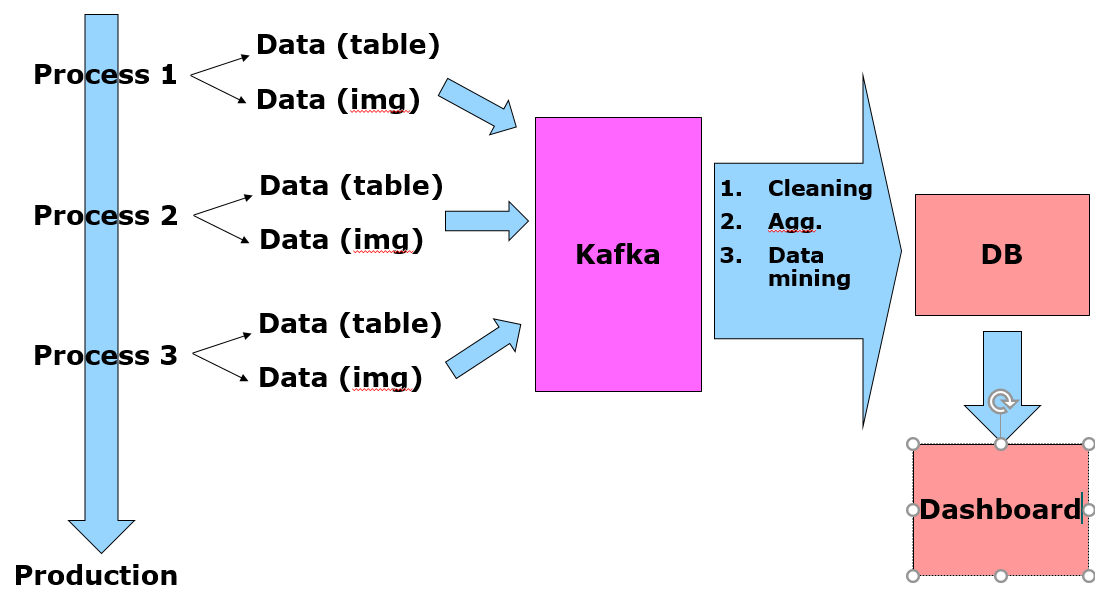

In [6]:
Image('/home/jovyan/ch06_streaming/why.PNG')

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, TimestampType, DoubleType, LongType
import pyspark.sql.functions as F

from IPython.display import Image
from time import sleep
spark = SparkSession \
    .builder \
    .appName("SSS") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

spark.conf.set('spark.sql.shuffle.partitions', 5) # default : 200

In [2]:
dataSchema = StructType([
    StructField('Arrival_time', LongType(), True),
    StructField('Creation_time', LongType(), True),
    StructField('device', StringType(), True),
    StructField('Index', LongType(), True),
    StructField('model', StringType(), True),
    StructField('user', StringType(), True),
    StructField('gt', StringType(), True),
    StructField('x', DoubleType(), True),
    StructField('y', DoubleType(), True),
    StructField('z', DoubleType(), True),
])

In [3]:
streaming = spark\
    .readStream\
    .schema(dataSchema)\
    .option('maxFilesPerTrigger', 5)\
    .json("/home/jovyan/ch06_streaming/activity-data/")

In [4]:
activityCounts = streaming.groupBy('gt').count()

In [5]:
activityQuery = activityCounts.writeStream.queryName('activity_counts')\
                .format('memory').outputMode('complete')\
                .start()

In [6]:
activityQuery.awaitTermination() # Not necessary for jupyter enviroment but necessary for production

KeyboardInterrupt: 

In [7]:
spark.streams.active

In [8]:
from time import sleep

for x in range(5):
    spark.sql('SELECT * FROM activity_counts').show()
    sleep(1)

+----------+------+
|        gt| count|
+----------+------+
|       sit| 98471|
|     stand| 91079|
|stairsdown| 74922|
|      walk|106048|
|  stairsup| 83614|
|      null| 83584|
|      bike| 86377|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit| 98471|
|     stand| 91079|
|stairsdown| 74922|
|      walk|106048|
|  stairsup| 83614|
|      null| 83584|
|      bike| 86377|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|110778|
|     stand|102464|
|stairsdown| 84286|
|      walk|119304|
|  stairsup| 94067|
|      null| 94033|
|      bike| 97175|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|123085|
|     stand|113849|
|stairsdown| 93648|
|      walk|132560|
|  stairsup|104521|
|      null|104482|
|      bike|107974|
+----------+------+

+----------+------+
|        gt| count|
+----------+------+
|       sit|123085|
|     stand|113849|
|stairsdown| 936

# Transformation

### 집계

In [4]:
deviceModelStats = streaming.cube("gt", "model").avg()\
  .drop("avg(Arrival_time)")\
  .drop("avg(Creation_Time)")\
  .drop("avg(Index)")\

deviceModelStatsQuery = deviceModelStats\
                        .writeStream\
                        .queryName('device_counts')\
                        .format('memory')\
                        .outputMode('complete')\
                        .start()

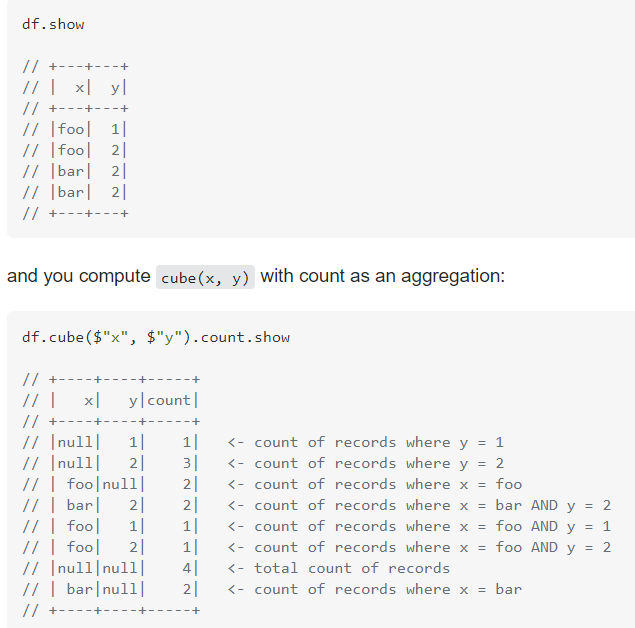

In [49]:
Image('/home/jovyan/ch06_streaming/cube.PNG')

In [12]:
for x in range(3):
    spark.sql('SELECT * FROM device_counts').show(3)
    sleep(0.5)

+-----+-----+--------------------+--------------------+--------------------+
|   gt|model|              avg(x)|              avg(y)|              avg(z)|
+-----+-----+--------------------+--------------------+--------------------+
| null| null|-0.00770507896980...|4.422727835309388...|0.003804983187970...|
|  sit| null|-5.29363993835280...|2.538895684873082E-4|-1.62768353594479...|
|stand| null|-3.42584586409025...|3.264317857541239E-4|2.777406172557846E-4|
+-----+-----+--------------------+--------------------+--------------------+
only showing top 3 rows

+-----+-----+--------------------+--------------------+--------------------+
|   gt|model|              avg(x)|              avg(y)|              avg(z)|
+-----+-----+--------------------+--------------------+--------------------+
| null| null|-0.00770507896980...|4.422727835309388...|0.003804983187970...|
|  sit| null|-5.29363993835280...|2.538895684873082E-4|-1.62768353594479...|
|stand| null|-3.42584586409025...|3.264317857541239

### 조인

### Static

In [3]:
static = spark.read.json("/home/jovyan/ch06_streaming/activity-data/")

In [19]:
historicalAgg = static.drop('Arrival_time', 'Creation_time', 'Index')\
            .groupBy('gt', 'model').avg()\
            .withColumnRenamed('avg(x)', 'staticAvgX')\
            .withColumnRenamed('avg(y)', 'staticAvgY')\
            .withColumnRenamed('avg(z)', 'staticAvgZ')

### Dynamic

In [22]:
deviceModelStats = streaming.drop('Arrival_time', 'Creation_time', 'Index')\
                .cube('gt', 'model').avg()\
                .join(historicalAgg, ['gt', 'model'])

In [23]:
deviceModelStatsQuery = deviceModelStats\
                        .writeStream\
                        .queryName('device_counts')\
                        .format('memory')\
                        .outputMode('complete')\
                        .start()

IllegalArgumentException: Cannot start query with name device_counts as a query with that name is already active in this SparkSession

In [20]:
for x in range(3):
    spark.sql('SELECT * FROM device_counts').show(3)
    sleep(1)

+---+-----+------+------+------+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+------+------+------+
+---+-----+------+------+------+------+------+------+

+---+-----+------+------+------+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+------+------+------+
+---+-----+------+------+------+------+------+------+

+---+-----+------+------+------+------+------+------+
| gt|model|avg(x)|avg(y)|avg(z)|avg(x)|avg(y)|avg(z)|
+---+-----+------+------+------+------+------+------+
+---+-----+------+------+------+------+------+------+



In [21]:
historicalAgg.head(3)

[Row(gt='bike', model='nexus4', staticAvgX=0.02268875955086685, staticAvgY=-0.008779121563686751, staticAvgZ=-0.08251001663412344),
 Row(gt='null', model='nexus4', staticAvgX=-0.008476888601096468, staticAvgY=-0.0007304552587391882, staticAvgZ=0.0030906014914199326),
 Row(gt='stairsdown', model='nexus4', staticAvgX=0.021613908669165436, staticAvgY=-0.03249018824752617, staticAvgZ=0.12035922691504071)]

# 이벤트 시간 처리

* 이벤트 시간 : 데이터에 기록되어있는 시간. 순차적으로 온다는 보장없음.
* 처리 시간 : 말그대로 처리시간

### 1. 텀블링 윈도우 --> 데이터 시간 기반

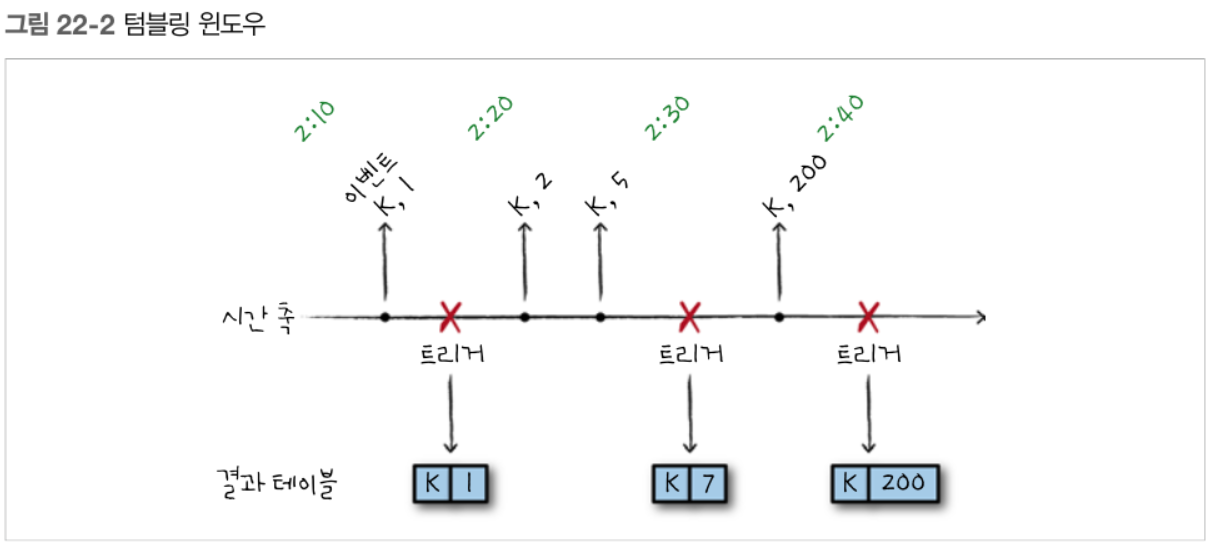

In [7]:
Image('/home/jovyan/ch06_streaming/tumbling.PNG')

타임 스템프 컬럼을 적절한 스파크 sql 타임스템프 데이터 타입으로 변환

    --> 나노 세컨드 단위의 유닉스시간을 적절한 포맷으로 변환

In [4]:
withEventTime = streaming.selectExpr(
  "*",
  "cast(cast(Creation_Time as double)/1000000000 as timestamp) as event_time")

10분길이의 윈도우 사용

In [6]:
withEventTime.groupBy(F.window(F.col("event_time"), "10 minutes")).count()\
  .writeStream\
  .queryName("pyevents_per_window")\
  .format("memory")\
  .outputMode("complete")\
  .start()

In [28]:
for x in range(3):
    spark.sql('SELECT * FROM pyevents_per_window').show(3)
    sleep(1)

+------+-----+
|window|count|
+------+-----+
+------+-----+

+------+-----+
|window|count|
+------+-----+
+------+-----+

+------+-----+
|window|count|
+------+-----+
+------+-----+



In [30]:
withEventTime.groupBy(F.window(F.col("event_time"), "10 minutes"), F.col("user")).count()\
  .writeStream\
  .queryName("pyevents_per_window2")\
  .format("memory")\
  .outputMode("complete")\
  .start()

In [45]:
for x in range(3):
    spark.sql('SELECT * FROM pyevents_per_window2').show(3)
    sleep(1)

+------+----+-----+
|window|user|count|
+------+----+-----+
+------+----+-----+

+------+----+-----+
|window|user|count|
+------+----+-----+
+------+----+-----+

+------+----+-----+
|window|user|count|
+------+----+-----+
+------+----+-----+



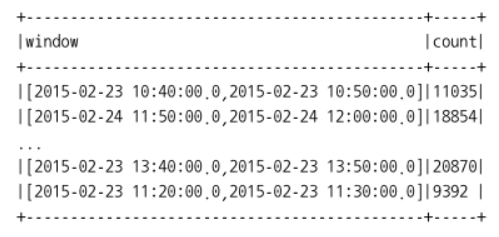

In [23]:
Image('/home/jovyan/ch06_streaming/tumbling_res.PNG')

### 2. 슬라이딩 윈도우 --> 겹겹이 ?

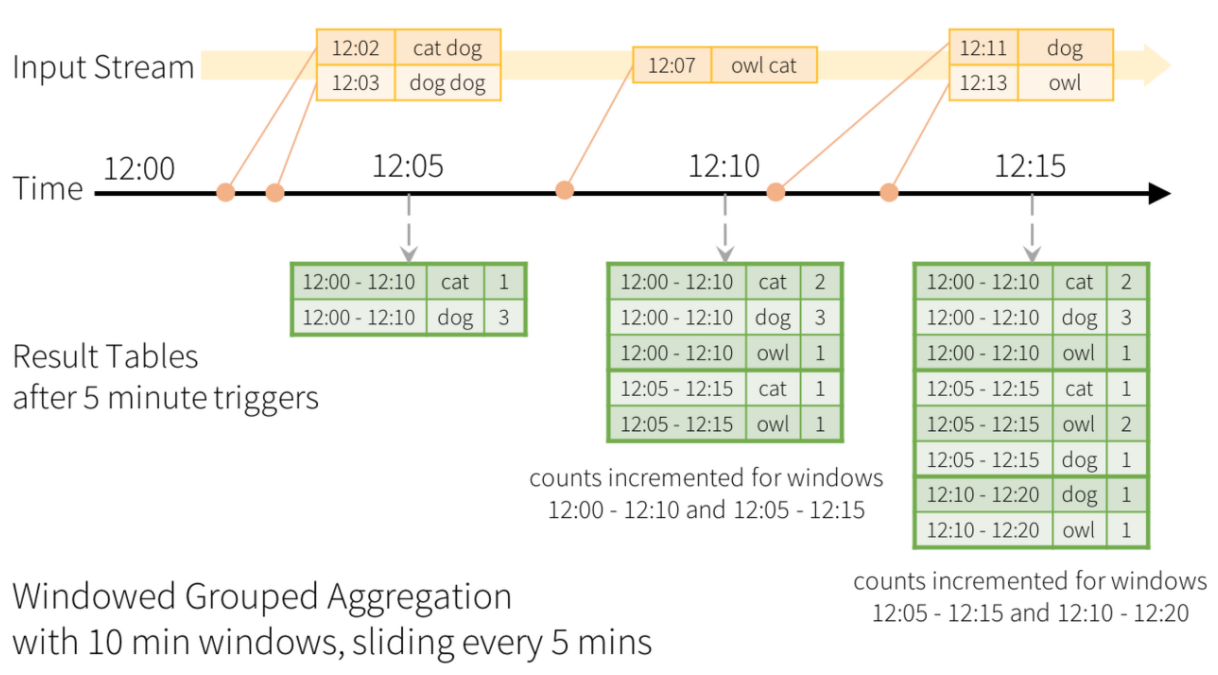

In [48]:
Image('/home/jovyan/ch06_streaming/sliding.PNG')

In [42]:
withEventTime.groupBy(F.window(F.col("event_time"), "10 minutes", "5 minutes"))\
  .count()\
  .writeStream\
  .queryName("pyevents_per_window4")\
  .format("memory")\
  .outputMode("complete")\
  .start()

IllegalArgumentException: Cannot start query with name pyevents_per_window4 as a query with that name is already active in this SparkSession

In [44]:
for x in range(3):
    spark.sql('SELECT * FROM pyevents_per_window4').show(3)
    sleep(1)

+------+-----+
|window|count|
+------+-----+
+------+-----+

+------+-----+
|window|count|
+------+-----+
+------+-----+

+------+-----+
|window|count|
+------+-----+
+------+-----+



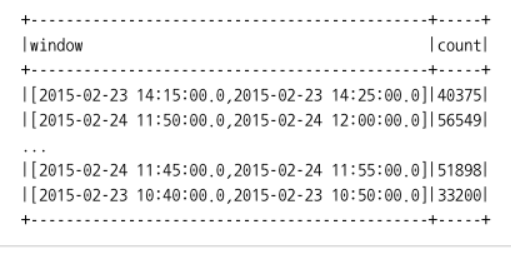

In [37]:
Image('/home/jovyan/ch06_streaming/sliding_res.PNG')

## 3. 워터마크로 지연 데이터 제어하기

### 워터마크가 필요한 이유

    워터마크가 없으면 중간 결과 데이터를 영원히 저장 -> 부하 상승 ==> 오래된 데이터는 제거

예) 10분 워터마크 --> 10분 이내의 이벤트만 받아들임.

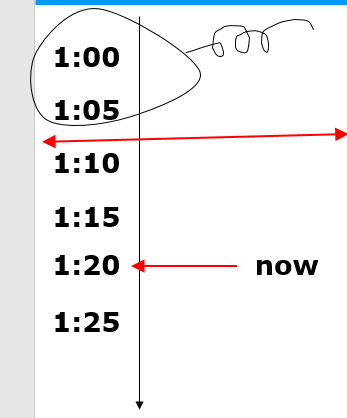

In [47]:
Image('/home/jovyan/ch06_streaming/watermark.PNG')

* 30 분 지연까지 봐줌

In [ ]:
withEventTime\
  .withWatermark("event_time", "30 minutes")\
  .groupBy(F.window(F.col("event_time"), "10 minutes", "5 minutes"))\
  .count()\
  .writeStream\
  .queryName("pyevents_per_window")\
  .format("memory")\
  .outputMode("complete")\
  .start()

# Kafka

* Prooduce data

In [ ]:
from kafka import KafkaProducer
import json
import time


class ProducerServer(KafkaProducer):

    def __init__(self, input_file, topic, **kwargs):
        super().__init__(**kwargs)
        self.input_file = input_file
        self.topic = topic

    #TODO we're generating a dummy data
    def generate_data(self):
        with open(self.input_file) as f:
            lines = json.load(f)
            for line in lines:
                message = self.dict_to_binary(line)
                # TODO send the correct data
                self.send(self.topic, message)
                time.sleep(0.1)

    # TODO fill this in to return the json dictionary to binary
    def dict_to_binary(self, json_dict):
        return json.dumps(json_dict).encode('utf-8')
        

In [ ]:
import producer_server


def run_kafka_server():
    
    input_file = "C:/Users/sanggyu.biern/Kafka/2. SF Crime Statistics with Spark Streaming/police-department-calls-for-service.json"

    # TODO fill in blanks
    producer = producer_server.ProducerServer(
        input_file=input_file,
        topic="crime.police-event",
        bootstrap_servers="localhost:9092",
        client_id="crime.broker"
    )

    return producer


def feed():
    producer = run_kafka_server()
    producer.generate_data()


if __name__ == "__main__":
    feed()


* Consume data

In [ ]:
import findspark
findspark.init(r"C:\hehe\spark-3.0.1-bin-hadoop2.7")
import os
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.12-3.0.1 spark-shell'
os.environ['HADOOP_HOME']  = r'C:\winutils'
import logging
import json
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as psf



# TODO Create a schema for incoming resources
schema = StructType([
    StructField('crime_id', LongType()),
    StructField('original_crime_type_name', StringType()),
    StructField('report_date', TimestampType()),
    StructField('call_date', TimestampType()),
    StructField('offense_date', TimestampType()),
    StructField('call_time', StringType()),
    StructField('call_date_time', TimestampType()),
    StructField('disposition', StringType()),
    StructField('address', StringType()),
    StructField('city', StringType()),
    StructField('state', StringType()),
    StructField('agency_id', IntegerType()),
    StructField('address_type', StringType()),
    StructField('common_location', StringType()),
])

def run_spark_job(spark):

    # TODO Create Spark Configuration
    # Create Spark configurations with max offset of 200 per trigger
    # set up correct bootstrap server and port
    df = spark \
        .readStream \
        .format('kafka') \
        .option('kafka.bootstrap.servers', 'localhost:9092')\
        .option('subscribe', 'crime.police-event') \
        .option('startingOffsets', 'earliest') \
        .option('maxOffsetPerTrigger', 5000) \
        .option('stopGracefullyOnShutdown', 'true')\
        .option('spark.sql.shuffle.partitions', 2)\
        .option('spark.streaming.kafka.maxRatePerPartition', 10)\
        .option('spark.default.parallelism', 10000)\
        .option('spark.sql.streaming.forceDeleteTempCheckpointLocation', 'true')\
        .load()
        #.option('spark.sql.streaming.forceDeleteTempCheckpointLocation', 'true')\
        
        

    # Show schema for the incoming resources for checks
    df.printSchema()

    # TODO extract the correct column from the kafka input resources
    # Take only value and convert it to String
    kafka_df = df.selectExpr("CAST(value AS STRING)")

    service_table = kafka_df\
        .select(psf.from_json(psf.col('value'), schema).alias("DF"))\
        .select("DF.*")
    
    service_table.printSchema()

    # TODO select original_crime_type_name and disposition
    distinct_table = service_table\
                    .select('original_crime_type_name', 'disposition', 'call_date_time')\
                    .distinct()

    # count the number of original crime type
    agg_df = distinct_table \
            .dropna()\
            .select('original_crime_type_name', 'call_date_time', "disposition") \
            .withWatermark('call_date_time', '60 minutes') \
            .groupBy('original_crime_type_name') \
            .count()
    #.count()

    # TODO Q1. Submit a screen shot of a batch ingestion of the aggregation
    # TODO write output stream
    query = agg_df \
            .writeStream \
            .format('console') \
            .outputMode('Update') \
            .trigger(processingTime="30 seconds") \
            .start()

    
    # TODO attach a ProgressReporter
    query.awaitTermination()
    print('======================finish await? =========================')
    # TODO get the right radio code json path
    radio_code_json_filepath = "C:/Users/sanggyu.biern/Kafka/2. SF Crime Statistics with Spark Streaming/radio_code.json"
    radio_code_df = spark.read.option("multiline","true").json(radio_code_json_filepath)

    # clean up your data so that the column names match on radio_code_df and agg_df
    # we will want to join on the disposition code
    
    # TODO rename disposition_code column to disposition
    radio_code_df = radio_code_df.withColumnRenamed("disposition_code", "disposition")

    # TODO join on disposition column
    join_query = agg_df.join(radio_code_df, agg_df.disposition == radio_code_df.disposition, how="left")


    join_query.awaitTermination()


if __name__ == "__main__":
    logger = logging.getLogger(__name__)

    # TODO Create Spark in Standalone mode
    spark = SparkSession \
        .builder \
        .config('spark.ui.port', 3002)\
        .appName("KafkaSparkStructuredStreaming2") \
        .getOrCreate()

    logger.info("Spark started")

    run_spark_job(spark)

    spark.stop()


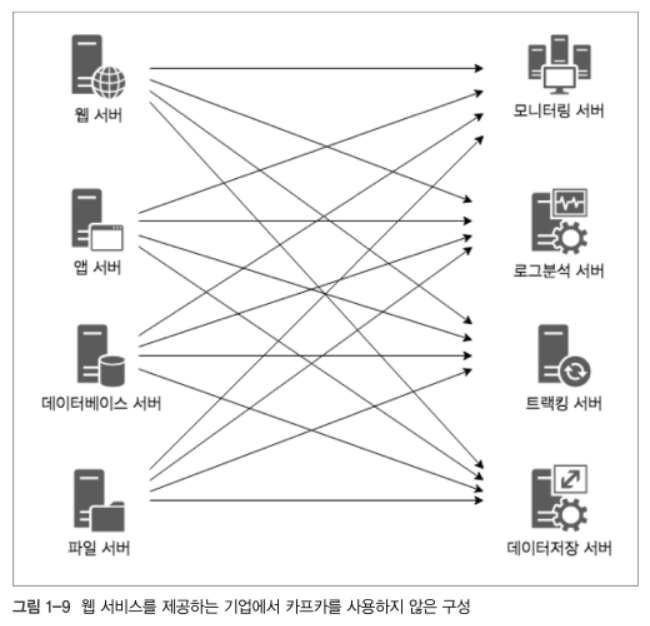

In [24]:
Image('/home/jovyan/ch06_streaming/noKafka.PNG')

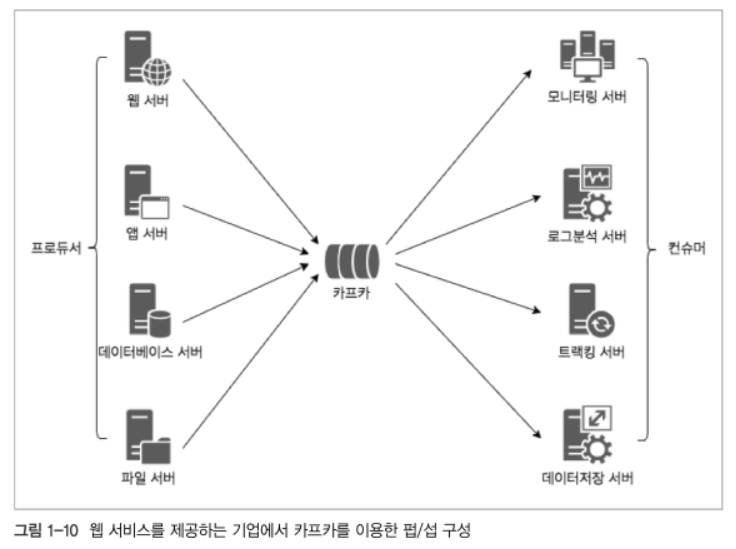

In [25]:
Image('/home/jovyan/ch06_streaming/Kafka.PNG')

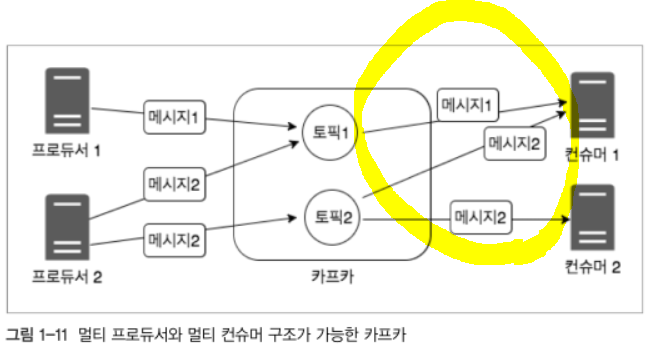

In [26]:
Image('/home/jovyan/ch06_streaming/KafkaSpark.PNG')